# Unit08｜工業回歸：軟感測器 (Soft Sensor)

對應講義：`Part_2/Unit08_SoftSensor_and_Cheminformatics.md`

**選讀附錄**：對化學資訊學感興趣的同學，請參考：
- 📖 [Unit08_Appendix_Cheminformatics.md](Unit08_Appendix_Cheminformatics.md)
- 📓 [Unit08_Appendix_Cheminformatics.ipynb](../Jupyter_Scripts/Unit08_Appendix_Cheminformatics.ipynb)

In [17]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'Part_2'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('P2_Unit08_SoftSensor_Results', exist_ok=True)
os.makedirs('P2_Unit08_Cheminfo_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2


## Soft Sensor：軟感測器開發 (Soft Sensor)

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）

**本單元目標**：
1.  **數據模擬**：模擬一段包含溫度 (T)、壓力 (P)、流量 (F) 與實驗室純度 (Lab Purity) 的製程數據。
2.  **模型訓練**：使用 **Gradient Boosting Regressor (梯度提升回歸)** 建立軟感測器，預測難以即時量測的產品純度。
3.  **模型評估**：計算 MAE、RMSE、R²，並透過 Parity Plot 與殘差圖驗證模型可靠性。
4.  **特徵重要性**：分析哪些操作變數對產品品質影響最大。

**什麼是軟感測器 (Soft Sensor)？**
在化工廠中，某些關鍵品質指標（如濃度、黏度、純度）需要實驗室取樣分析，會有數小時的延遲。軟感測器利用容易取得的即時數據（T, P, F），透過數學模型「即時推算」出品質指標，實現即時監控與控制。

In [18]:
# 匯入必要的套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 建立結果儲存資料夾
OUTPUT_DIR = REPO_ROOT / 'Part_2' / 'P2_Unit08_SoftSensor_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(REPO_ROOT / 'Part_2')

# 圖形設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


---
## 1. 模擬製程數據 (Data Generation)

我們模擬一個反應製程，其中產品純度受到操作條件的影響：
- **溫度 (T)**：過高會導致副反應，降低純度。
- **壓力 (P)**：壓力越高，反應越完全，純度提升。
- **流量 (F)**：流量偏離設計值 (50 L/min) 會導致停留時間不佳，純度下降。

我們加入一些隨機雜訊 (Noise) 來模擬真實世界的測量誤差。

In [19]:
np.random.seed(101)
n_samples = 2000

# 輸入變數 (Features)
T = np.random.normal(150, 5, n_samples)   # Temperature (°C)
P = np.random.normal(5, 0.2, n_samples)   # Pressure (bar)
F = np.random.normal(50, 2, n_samples)    # FlowRate (L/min)

# 定義「真實」機制 (Ground Truth)
noise = np.random.normal(0, 0.3, n_samples)

# 純度公式：包含線性項與非線性項 (流量平方)
purity = (
    98.0
    - 0.15 * (T - 150.0)         # 溫度越高，副反應越多 → 純度降低
    + 2.5 * (P - 5.0)           # 壓力越高，反應較完全 → 純度增加
    - 0.02 * (F - 50.0) ** 2    # 流量偏離設計值，停留時間不佳 → 純度下降
    + noise
)

# 建立 DataFrame
df = pd.DataFrame(
    {
        "Temperature": T,
        "Pressure": P,
        "FlowRate": F,
        "Lab_Purity": purity,
    }
)

print(f"已生成 {n_samples} 筆模擬資料。")
display(df.head())
display(df.describe().round(2))

已生成 2000 筆模擬資料。


,Temperature,Pressure,FlowRate,Lab_Purity
0,163.534249,4.696660,45.893391,95.628679
1,153.140664,5.233480,52.901128,97.594701
2,154.539847,5.181971,53.403075,97.128059
3,152.519129,4.986710,48.834984,98.038294
4,153.255590,4.958227,51.887741,97.230776


,Temperature,Pressure,FlowRate,Lab_Purity
count,2000.00,2000.00,2000.00,2000.00
mean,150.19,5.01,50.03,97.90
std,5.20,0.20,2.03,1.00
min,130.40,4.36,43.29,94.01
25%,146.60,4.87,48.62,97.22
50%,150.14,5.01,50.05,97.89
75%,153.81,5.14,51.41,98.60
max,171.30,5.67,56.87,101.04


---
## 2. 訓練軟感測器模型 (Model Training)

我們將使用 **Gradient Boosting Regressor**。這是一種強大的集成學習演算法，能夠很好地捕捉非線性關係（例如流量對純度的二次方影響）。

步驟：
1.  定義特徵 (X) 與目標 (y)。
2.  切分訓練集 (80%) 與測試集 (20%)。
3.  訓練模型。

---
## 1.5 集成學習理論速覽：為何選擇 Gradient Boosting？

在開始訓練模型前，我們先理解**為什麼要用 Gradient Boosting**，以及它與其他集成學習方法的差異。

### 集成學習 (Ensemble Learning) 的核心思想

**「三個臭皮匠，勝過一個諸葛亮」**

集成學習的核心是：**組合多個弱學習器（Weak Learners）成為一個強學習器（Strong Learner）**。

### 兩大集成策略：Bagging vs Boosting

| 維度 | **Bagging** | **Boosting** |
|------|------------|--------------|
| **代表算法** | Random Forest | AdaBoost, Gradient Boosting, XGBoost |
| **訓練方式** | **並行訓練**：每棵樹獨立訓練 | **串行訓練**：後一棵樹專注修正前一棵的錯誤 |
| **數據取樣** | Bootstrap（有放回抽樣）| 全部數據，但調整樣本權重 |
| **組合方式** | 平均（回歸）或投票（分類）| 加權求和 |
| **降低問題** | **降低變異 (Variance)**<br>避免過擬合 | **降低偏差 (Bias)**<br>提升準確率 |
| **適用場景** | 數據噪音多、需要穩健性 | 需要高準確率、可接受計算成本 |

### Gradient Boosting 的運作原理

**核心公式**：

$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$

其中：
- $F_m(x)$：第 $m$ 輪的模型
- $h_m(x)$：第 $m$ 棵決策樹（學習殘差）
- $\nu$：學習率（learning rate），控制每棵樹的貢獻

**訓練流程**：
1. **初始化**：$F_0(x) = \bar{y}$（使用均值作為初始預測）
2. **迭代 m = 1 to M**：
   - 計算殘差：$r_m = y - F_{m-1}(x)$
   - 訓練新樹 $h_m(x)$ 去擬合殘差 $r_m$
   - 更新模型：$F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$
3. **最終模型**：$F(x) = F_M(x)$

**直觀理解**：
- **第一棵樹**：學習大致趨勢（例如溫度與純度的主要關係）
- **第二棵樹**：學習第一棵樹的錯誤（例如壓力的影響）
- **第三棵樹**：學習前兩棵樹的剩餘錯誤（例如流量的非線性效應）
- ... 持續修正，直到殘差足夠小

### 為何 Gradient Boosting 適合軟測量儀表？

| 特性 | 化工軟測量需求 | Gradient Boosting 的優勢 |
|------|--------------|------------------------|
| **非線性關係** | 溫度、壓力、流量對純度的影響複雜 | ✅ 自動捕捉非線性交互作用 |
| **特徵重要性** | 需要知道哪些變數最關鍵 | ✅ 內建 `feature_importances_` |
| **準確率要求** | 軟測量誤差要 < 1-2% | ✅ 通常優於單一模型 |
| **抗噪能力** | 現場數據有測量誤差 | ✅ Boosting 對異常值相對穩健 |
| **可解釋性** | 需要向現場解釋模型邏輯 | ⚠️ 比 Decision Tree 差，但可用 SHAP 輔助 |

### Random Forest vs Gradient Boosting 的選擇

**何時選 Random Forest？**
- 數據量大且噪音多（需要穩健性）
- 訓練速度要快（並行訓練）
- 不想調太多超參數

**何時選 Gradient Boosting？**
- 需要最高準確率（可接受較慢訓練）
- 數據有清晰的模式待挖掘
- 願意調參（`n_estimators`, `learning_rate`, `max_depth`）

**化工軟測量的推薦**：
- **初期探索**：Random Forest（快速驗證可行性）
- **生產部署**：Gradient Boosting（優化性能後鎖定參數）

---

In [20]:
# 定義 X 與 y
X = df[["Temperature", "Pressure", "FlowRate"]]
y = df["Lab_Purity"]

# 切分資料集
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"訓練集大小：{len(X_train)}，測試集大小：{len(X_test)}")

# 資料正規化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# 建立並訓練模型
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
model.fit(X_train_scaled, y_train_scaled)

print("✓ 軟感測器模型 (Gradient Boosting) 訓練完成。")

訓練集大小：1600，測試集大小：400
✓ 軟感測器模型 (Gradient Boosting) 訓練完成。


---
## 3. 模型評估 (Evaluation)

使用測試集來評估模型的預測能力。
- **R² (決定係數)**：越接近 1 越好，代表模型解釋了多少變異。
- **MAE (平均絕對誤差)**：預測值與真實值的平均差距。
- **RMSE (根均方誤差)**：對大誤差較敏感的指標。

In [21]:
# 進行預測

y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# 計算指標
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² (決定係數)：{r2:.4f}")
print(f"MAE (平均絕對誤差)：{mae:.4f} %")
print(f"RMSE (根均方誤差)：{rmse:.4f} %")

R² (決定係數)：0.9085
MAE (平均絕對誤差)：0.2463 %
RMSE (根均方誤差)：0.3013 %


---
## 4. 特徵重要性分析 (Feature Importance)

了解哪些操作變數對產品品質影響最大，有助於現場工程師進行製程調整。

In [22]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("特徵對純度的影響程度 (Feature Importance)：")
for rank, idx in enumerate(indices, start=1):
    print(f"{rank}. {feature_names[idx]}: {importances[idx]:.4f}")

特徵對純度的影響程度 (Feature Importance)：
1. Temperature: 0.6907
2. Pressure: 0.2866
3. FlowRate: 0.0227


---
## 5. 結果視覺化 (Visualization)

我們將繪製四張圖來全面分析軟感測器的性能：
1.  **Parity Plot**：預測值 vs 真實值，理想應落在對角線上。
2.  **Residual Distribution**：殘差應呈現常態分佈且中心為 0。
3.  **Feature Importance**：視覺化特徵權重。
4.  **Online Monitoring Simulation**：模擬線上運行的狀況，比較 AI 預測與實驗室數據的趨勢。

C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_68068\3579937082.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


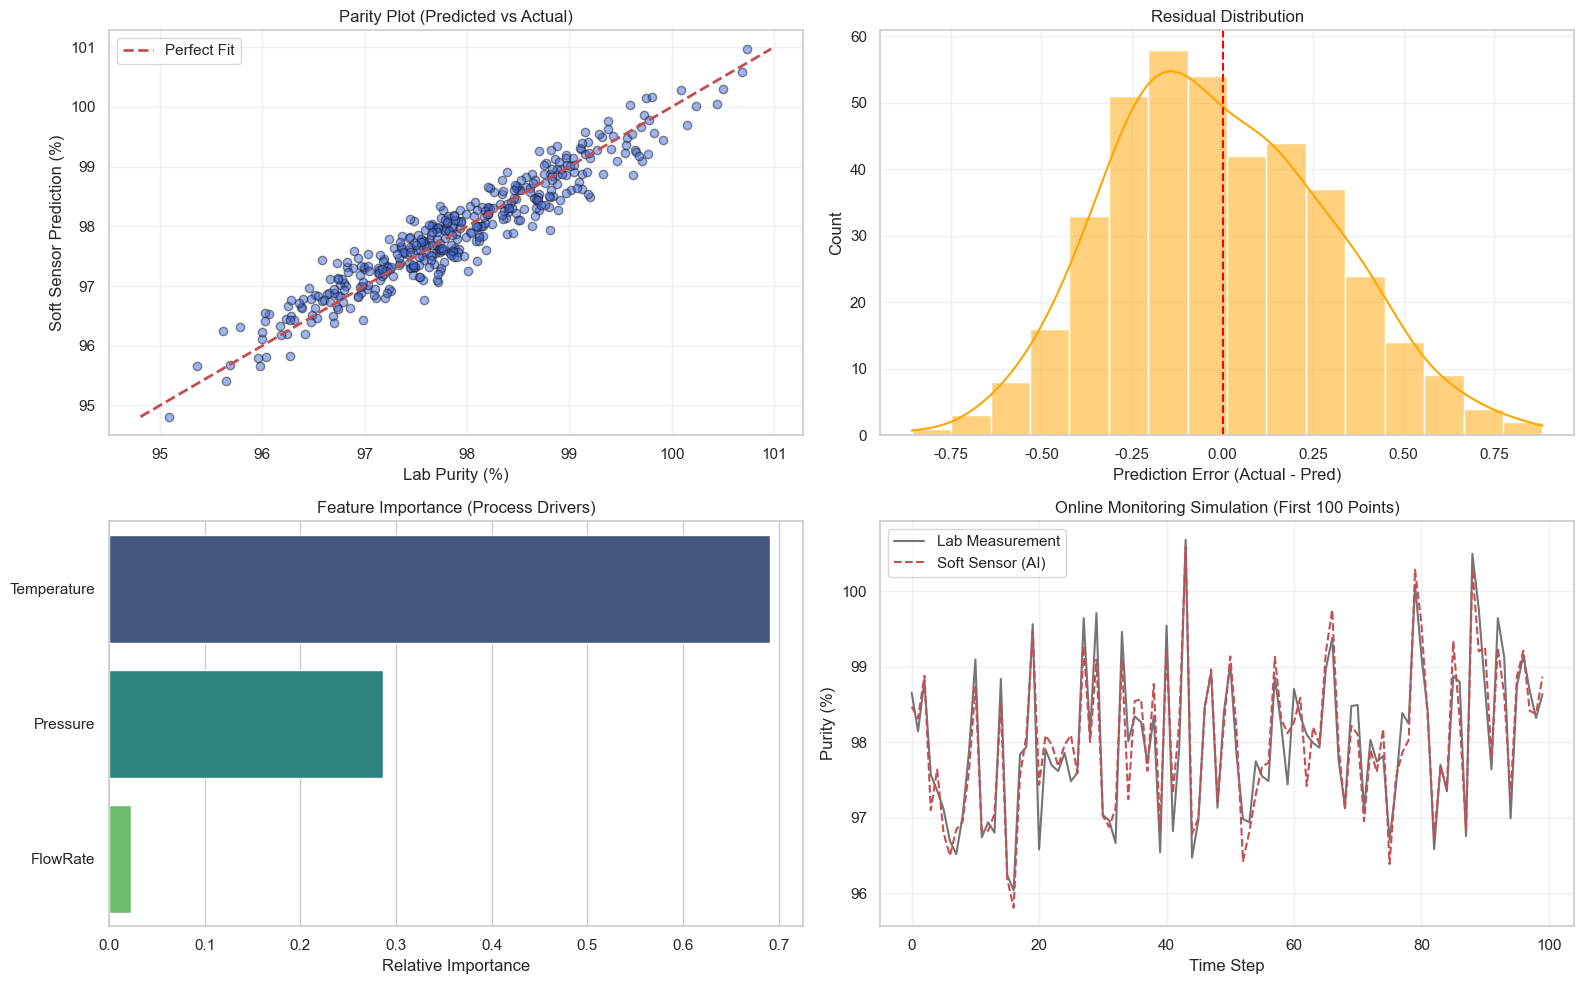

✓ 分析圖表已儲存至 P2_Unit08_SoftSensor_Results/soft_sensor_analysis.png


In [23]:
fig = plt.figure(figsize=(16, 10))

# 1. Parity Plot
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(y_test, y_pred, alpha=0.5, color="royalblue", edgecolor="k")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Fit")
ax1.set_xlabel("Lab Purity (%)")
ax1.set_ylabel("Soft Sensor Prediction (%)")
ax1.set_title("Parity Plot (Predicted vs Actual)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 殘差分布
ax2 = plt.subplot(2, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color="orange", ax=ax2)
ax2.axvline(0, color="red", linestyle="--")
ax2.set_xlabel("Prediction Error (Actual - Pred)")
ax2.set_title("Residual Distribution")
ax2.grid(True, alpha=0.3)

# 3. 特徵重要性
ax3 = plt.subplot(2, 2, 3)
sns.barplot(
    x=[importances[i] for i in indices],
    y=[feature_names[i] for i in indices],
    palette="viridis",
    ax=ax3,
)
ax3.set_title("Feature Importance (Process Drivers)")
ax3.set_xlabel("Relative Importance")

# 4. 線上監控模擬 (取測試集前 100 點)
ax4 = plt.subplot(2, 2, 4)
n_points = min(100, len(y_test))
t_sim = np.arange(n_points)
y_test_np = y_test.iloc[:n_points].values
y_pred_np = y_pred[:n_points]

ax4.plot(t_sim, y_test_np, "k-", label="Lab Measurement", alpha=0.6, linewidth=1.5)
ax4.plot(t_sim, y_pred_np, "r--", label="Soft Sensor (AI)", linewidth=1.5)
ax4.set_title("Online Monitoring Simulation (First 100 Points)")
ax4.set_xlabel("Time Step")
ax4.set_ylabel("Purity (%)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'soft_sensor_analysis.png')
plt.show()
print("✓ 分析圖表已儲存至 P2_Unit08_SoftSensor_Results/soft_sensor_analysis.png")

---
## 6. 進階分析：模型比較 (Model Comparison)

在實務中，我們需要比較不同演算法的效能，選擇最適合的模型。
讓我們比較 Gradient Boosting 與其他常見演算法。

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import time

# 定義要比較的模型
com_models = {
    'Linear Regression': LinearRegression(),
    'PLS Regression': PLSRegression(n_components=3),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
}

# 儲存結果
results = []

print("開始訓練與評估各模型...\n")
for name, model in com_models.items():
    # 所有模型都使用正規化資料
    X_train_model = X_train_scaled
    X_test_model = X_test_scaled
    y_train_model = y_train_scaled
    y_test_model = y_test_scaled
    # 訓練計時
    start_time = time.time()
    model.fit(X_train_scaled, y_train_scaled)
    train_time = time.time() - start_time
    
    # 預測
    y_pred_scaled = model.predict(X_test_scaled)
    # 所有模型都將預測值反轉回原始尺度
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    # 評估也用原始尺度
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'Model': name,
        'R²': np.round(r2, 4),
        'MAE': np.round(mae, 4),
        'RMSE': np.round(rmse, 4),
        'Training Time (s)': np.round(train_time, 6)
    })
    
    print(f"{name:20s} | R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Time: {train_time:.3f}s")

# 建立比較表格
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)
print("\n" + "="*80)
print("模型效能比較總表")
print("="*80)
display(results_df.round(4))

開始訓練與評估各模型...

Linear Regression    | R²: 0.8994 | MAE: 0.2530 | RMSE: 0.3160 | Time: 0.001s
PLS Regression       | R²: 0.8994 | MAE: 0.2530 | RMSE: 0.3160 | Time: 0.002s
Random Forest        | R²: 0.8942 | MAE: 0.2633 | RMSE: 0.3240 | Time: 0.846s
Gradient Boosting    | R²: 0.9085 | MAE: 0.2463 | RMSE: 0.3013 | Time: 0.451s
Neural Network       | R²: 0.9122 | MAE: 0.2388 | RMSE: 0.2951 | Time: 0.246s

模型效能比較總表


,Model,R²,MAE,RMSE,Training Time (s)
0,Neural Network,0.9122,0.2388,0.2951,0.2459
1,Gradient Boosting,0.9085,0.2463,0.3013,0.4513
2,Linear Regression,0.8994,0.2530,0.3160,0.0010
3,PLS Regression,0.8994,0.2530,0.3160,0.0020
4,Random Forest,0.8942,0.2633,0.3240,0.8460


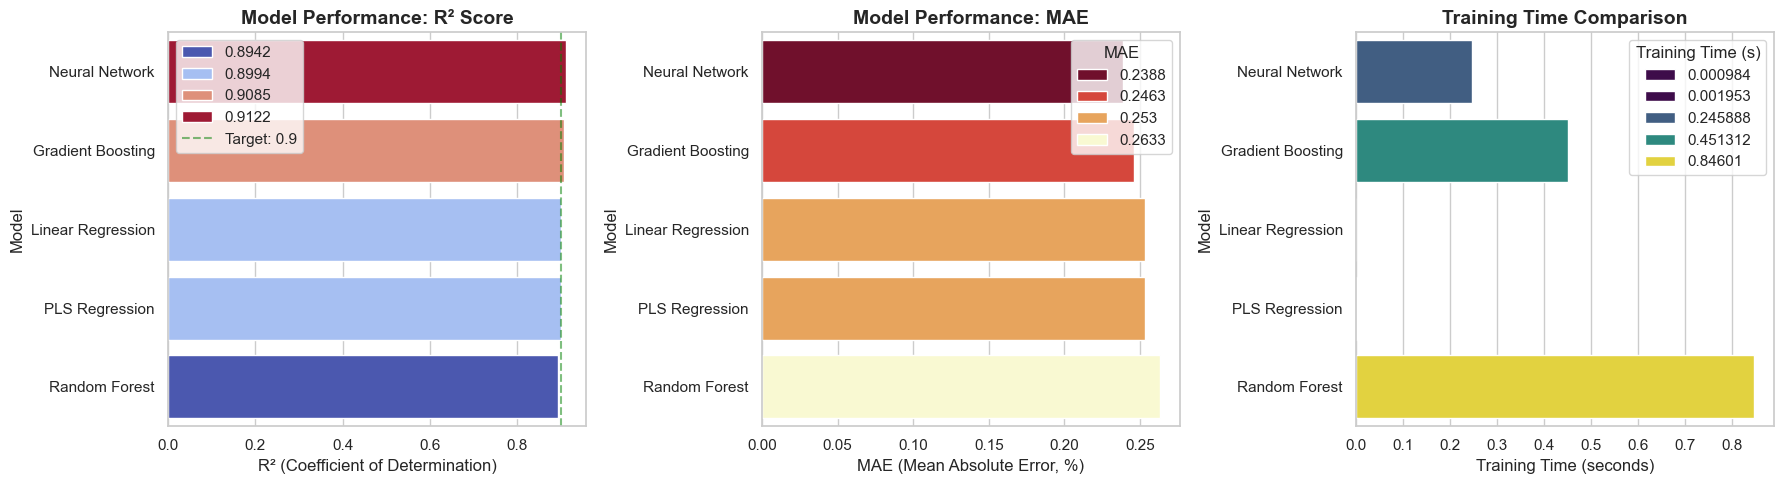

✓ 模型比較圖表已儲存


In [25]:
# 視覺化模型比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. R² 比較
ax1 = axes[0]
sns.barplot(data=results_df, y='Model', x='R²', hue='R²', palette='coolwarm', ax=ax1)
ax1.set_title('Model Performance: R² Score', fontsize=14, fontweight='bold')
ax1.set_xlabel('R² (Coefficient of Determination)')
ax1.axvline(0.9, color='green', linestyle='--', alpha=0.5, label='Target: 0.9')
ax1.legend()

# 2. MAE 比較 (越小越好)
ax2 = axes[1]
sns.barplot(data=results_df, y='Model', x='MAE', hue='MAE', palette='YlOrRd_r', ax=ax2)
ax2.set_title('Model Performance: MAE', fontsize=14, fontweight='bold')
ax2.set_xlabel('MAE (Mean Absolute Error, %)')

# 3. 訓練時間比較
ax3 = axes[2]
sns.barplot(data=results_df, y='Model', x='Training Time (s)', hue='Training Time (s)', palette='viridis', ax=ax3)
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Training Time (seconds)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison.png', dpi=150)
plt.show()
print("✓ 模型比較圖表已儲存")

---
## 7. 真實案例：蒸餾塔 C3/C4 分離製程

現在我們來模擬一個更接近真實工業的案例：**丙烷/丁烷分離蒸餾塔**。
這個案例包含更多特徵、時間延遲效應、以及更複雜的非線性關係。

In [26]:
# 模擬蒸餾塔數據（時序數據）
np.random.seed(2025)
n_timesteps = 3000  # 3000 個時間點（假設每分鐘採樣一次，共 50 小時）

# 時間索引
time_index = pd.date_range('2024-01-01', periods=n_timesteps, freq='1min')

# 基礎操作條件（包含時序變化，模擬製程波動）
T_top = 42 + 2 * np.sin(np.arange(n_timesteps) / 200) + np.random.normal(0, 0.5, n_timesteps)  # 塔頂溫度 (°C)
T_bottom = 85 + 3 * np.sin(np.arange(n_timesteps) / 300) + np.random.normal(0, 0.8, n_timesteps)  # 塔底溫度 (°C)
P_column = 18 + 0.5 * np.sin(np.arange(n_timesteps) / 250) + np.random.normal(0, 0.2, n_timesteps)  # 塔壓 (bar)
Reflux_Ratio = 1.8 + 0.3 * np.sin(np.arange(n_timesteps) / 180) + np.random.normal(0, 0.1, n_timesteps)  # 回流比
Q_reboiler = 25 + 2 * np.sin(np.arange(n_timesteps) / 220) + np.random.normal(0, 0.5, n_timesteps)  # 再沸器負荷 (MW)
F_feed = 100 + 5 * np.sin(np.arange(n_timesteps) / 150) + np.random.normal(0, 1, n_timesteps)  # 進料流量 (m³/h)

# 產品純度計算（含時間延遲效應）
# 真實製程中，進料變化不會立即影響產品品質，需要 8-12 分鐘的延遲
delay_steps = 10  # 10 分鐘延遲

# 初始化純度陣列
C3_purity = np.zeros(n_timesteps)

# 基準純度
base_purity = 95.0

for t in range(delay_steps, n_timesteps):
    # 使用延遲的變數
    T_top_delayed = T_top[t - delay_steps]
    P_delayed = P_column[t - delay_steps]
    Reflux_delayed = Reflux_Ratio[t - delay_steps]
    F_delayed = F_feed[t - delay_steps]
    
    # 複雜的非線性關係（基於蒸餾塔物理）
    purity = (
        base_purity
        - 0.8 * (T_top_delayed - 42)  # 塔頂溫度越高，輕組分逸出，純度下降
        + 0.3 * (P_delayed - 18)      # 壓力提升，分離效果改善
        + 2.5 * (Reflux_delayed - 1.8)  # 回流比是最關鍵因素
        - 0.01 * (F_delayed - 100)**2  # 流量偏離設計值，停留時間不佳
        + 0.05 * (T_bottom[t] - 85)    # 塔底溫度略有影響
        + np.random.normal(0, 0.2)     # 測量雜訊
    )
    
    C3_purity[t] = np.clip(purity, 90, 99)  # 限制在合理範圍

# 前 10 個點用初始值填補
C3_purity[:delay_steps] = C3_purity[delay_steps]

# 建立 DataFrame
df_distillation = pd.DataFrame({
    'Timestamp': time_index,
    'T_top': T_top,
    'T_bottom': T_bottom,
    'P_column': P_column,
    'Reflux_Ratio': Reflux_Ratio,
    'Q_reboiler': Q_reboiler,
    'F_feed': F_feed,
    'C3_Purity': C3_purity
})

print(f"✓ 已生成 {n_timesteps} 個時間點的蒸餾塔數據")
print(f"✓ 時間跨度：{time_index[0]} 至 {time_index[-1]}")
print("\n前 10 筆數據：")
display(df_distillation.head(10))
print("\n統計摘要：")
display(df_distillation.describe().round(2))

✓ 已生成 3000 個時間點的蒸餾塔數據
✓ 時間跨度：2024-01-01 00:00:00 至 2024-01-03 01:59:00

前 10 筆數據：


,Timestamp,T_top,T_bottom,P_column,Reflux_Ratio,Q_reboiler,F_feed,C3_Purity
0,2024-01-01 00:00:00,41.953805,85.575112,17.946158,1.595874,25.538726,98.969174,94.237872
1,2024-01-01 00:01:00,42.377143,85.109487,17.792468,1.776242,25.280425,98.518179,94.237872
2,2024-01-01 00:02:00,41.300559,85.049416,18.087064,1.663676,24.654548,98.663988,94.237872
3,2024-01-01 00:03:00,41.698288,86.356335,17.588558,1.849646,24.794987,99.212219,94.237872
4,2024-01-01 00:04:00,41.989633,83.034441,18.042793,1.669693,25.362972,100.158318,94.237872
5,2024-01-01 00:05:00,43.123488,84.915267,17.779926,1.806853,24.775219,99.864494,94.237872
6,2024-01-01 00:06:00,42.756845,86.448832,17.794068,1.761520,24.368832,99.987362,94.237872
7,2024-01-01 00:07:00,41.966300,85.655711,17.689677,1.717198,25.430204,100.907321,94.237872
8,2024-01-01 00:08:00,42.461772,85.000944,18.085036,1.844025,24.931988,99.077642,94.237872
9,2024-01-01 00:09:00,42.192496,84.935473,18.042798,1.849619,24.876133,100.803714,94.237872



統計摘要：


,Timestamp,T_top,T_bottom,P_column,Reflux_Ratio,Q_reboiler,F_feed,C3_Purity
count,3000,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,2024-01-02 00:59:30,42.23,85.56,18.00,1.83,25.08,100.15,94.78
min,2024-01-01 00:00:00,38.50,79.55,16.89,1.22,21.74,91.23,91.68
25%,2024-01-01 12:29:45,40.89,83.85,17.67,1.63,23.78,96.71,94.05
50%,2024-01-02 00:59:30,42.45,85.88,18.01,1.85,25.17,100.39,94.74
75%,2024-01-02 13:29:15,43.50,87.35,18.34,2.01,26.35,103.44,95.55
max,2024-01-03 01:59:00,45.43,90.25,19.08,2.40,28.32,108.58,97.84
std,NaN,1.49,2.18,0.41,0.23,1.48,3.66,1.08


### 7.1 時序數據視覺化

首先觀察製程變數與產品純度的時序變化，了解數據特性。

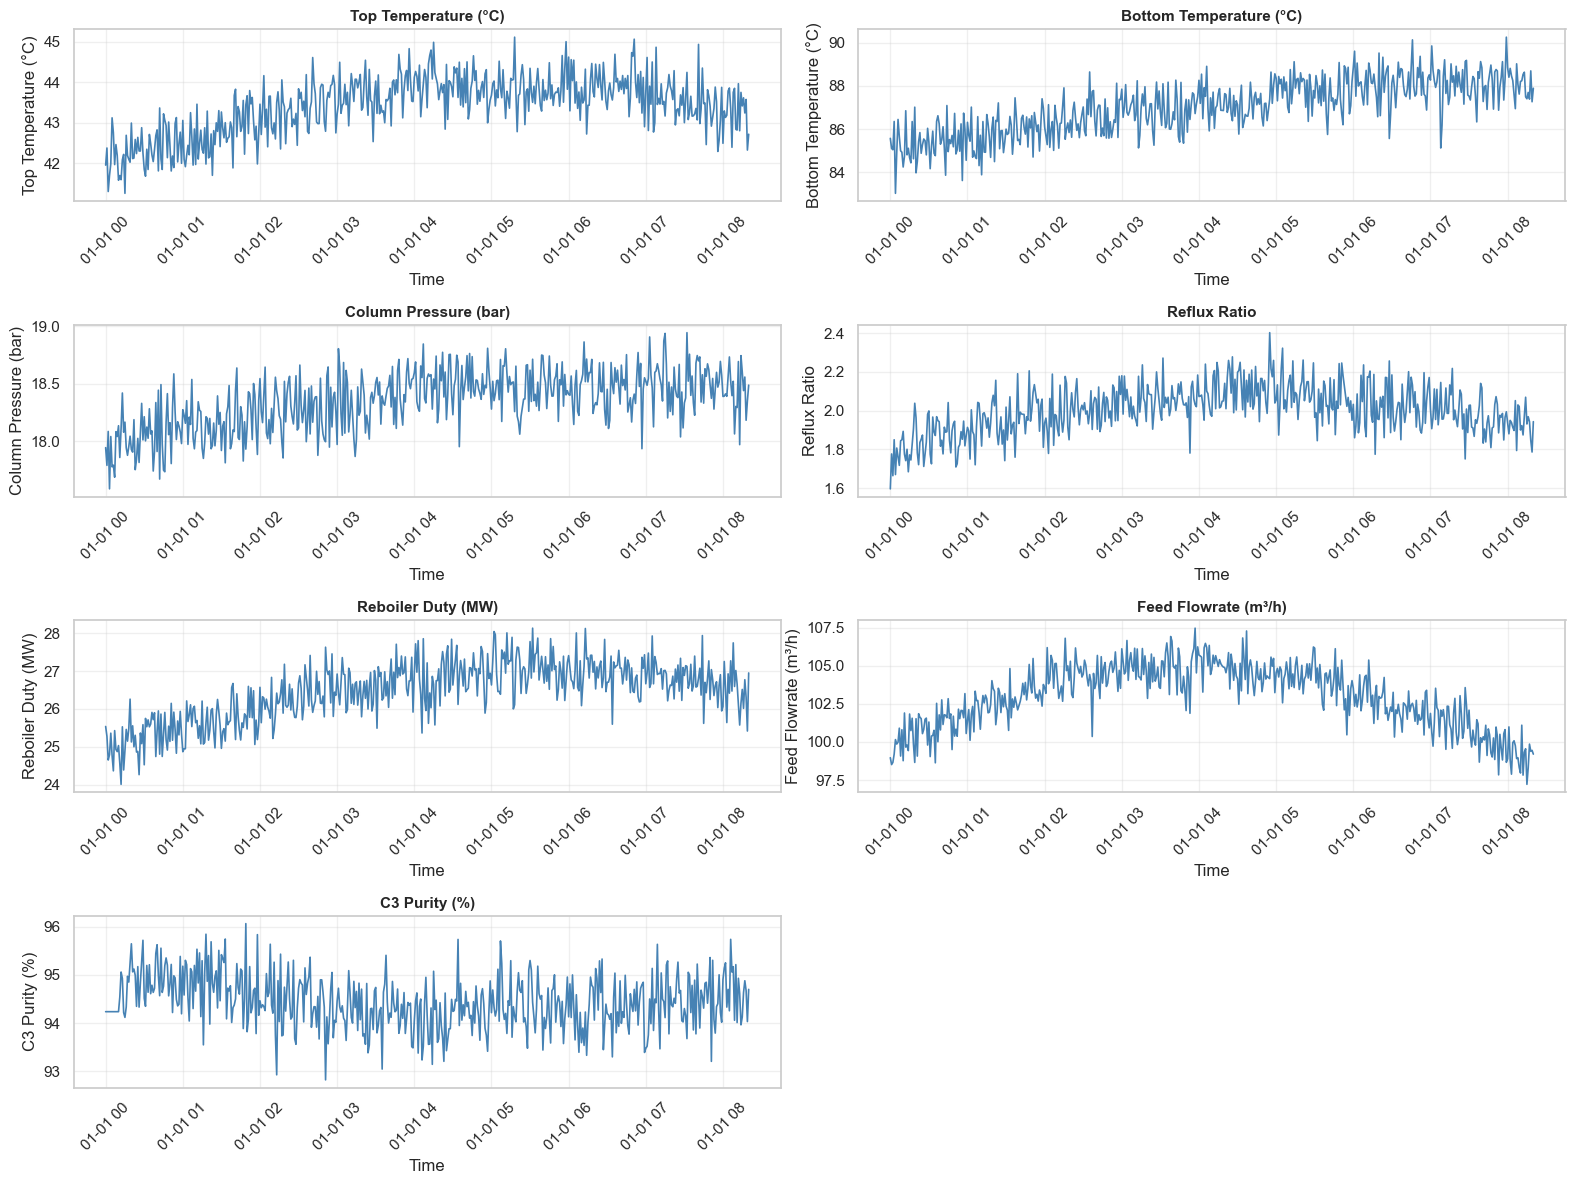

✓ 時序圖已儲存


In [27]:
# 繪製時序圖
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

variables = ['T_top', 'T_bottom', 'P_column', 'Reflux_Ratio', 'Q_reboiler', 'F_feed', 'C3_Purity']
labels = ['Top Temperature (°C)', 'Bottom Temperature (°C)', 'Column Pressure (bar)', 'Reflux Ratio',
          'Reboiler Duty (MW)', 'Feed Flowrate (m³/h)', 'C3 Purity (%)']

# 只顯示前 500 個時間點（約 8.3 小時）以便觀察細節
plot_range = slice(0, 500)

for idx, (var, label) in enumerate(zip(variables, labels)):
    ax = axes[idx]
    ax.plot(df_distillation.loc[plot_range, 'Timestamp'], 
            df_distillation.loc[plot_range, var], 
            linewidth=1.2, color='steelblue')
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# 隱藏最後一個空白子圖
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'distillation_timeseries.png', dpi=150)
plt.show()
print("✓ 時序圖已儲存")

### 7.2 處理時間延遲：創建滯後特徵

在真實製程中，輸入變數的變化不會立即影響輸出。
我們需要創建 **滯後特徵 (Lag Features)** 來捕捉這種時間延遲效應。

In [28]:
# 創建滯後特徵
def create_lag_features(df, lag_steps=[5, 10, 15]):
    """
    為時序數據創建滯後特徵
    
    Parameters:
    -----------
    df : DataFrame
        原始數據
    lag_steps : list
        要創建的滯後步數列表（分鐘）
    
    Returns:
    --------
    DataFrame with lag features
    """
    df_lag = df.copy()
    
    # 需要創建滯後特徵的變數
    lag_vars = ['T_top', 'P_column', 'Reflux_Ratio', 'F_feed']
    
    for var in lag_vars:
        for lag in lag_steps:
            df_lag[f'{var}_lag_{lag}min'] = df_lag[var].shift(lag)
    
    # 移除因滯後產生的 NaN 值
    df_lag = df_lag.dropna().reset_index(drop=True)
    
    return df_lag

# 創建滯後特徵
df_dist_lag = create_lag_features(df_distillation, lag_steps=[5, 10, 15])

print(f"✓ 原始特徵數：{len(df_distillation.columns)}") 
print(f"✓ 加入滯後特徵後：{len(df_dist_lag.columns)}")
print(f"✓ 有效數據點：{len(df_dist_lag)} (移除了前 15 個點的 NaN)")
print("\n新增的滯後特徵：")
lag_cols = [col for col in df_dist_lag.columns if 'lag' in col]
print(lag_cols)

✓ 原始特徵數：8
✓ 加入滯後特徵後：20
✓ 有效數據點：2985 (移除了前 15 個點的 NaN)

新增的滯後特徵：
['T_top_lag_5min', 'T_top_lag_10min', 'T_top_lag_15min', 'P_column_lag_5min', 'P_column_lag_10min', 'P_column_lag_15min', 'Reflux_Ratio_lag_5min', 'Reflux_Ratio_lag_10min', 'Reflux_Ratio_lag_15min', 'F_feed_lag_5min', 'F_feed_lag_10min', 'F_feed_lag_15min']


### 7.3 訓練蒸餾塔軟感測器（含滯後特徵）

比較「無滯後特徵」vs.「有滯後特徵」的模型效能。

In [29]:
# 情境 1：不考慮時間延遲（錯誤做法）
feature_cols_no_lag = ['T_top', 'T_bottom', 'P_column', 'Reflux_Ratio', 'Q_reboiler', 'F_feed']
X_dist_no_lag = df_dist_lag[feature_cols_no_lag]
y_dist = df_dist_lag['C3_Purity']

# 情境 2：考慮時間延遲（正確做法）
feature_cols_with_lag = feature_cols_no_lag + lag_cols
X_dist_with_lag = df_dist_lag[feature_cols_with_lag]

# 時序切分（前 80% 訓練，後 20% 測試）
split_idx = int(len(df_dist_lag) * 0.8)

X_train_no_lag, X_test_no_lag = X_dist_no_lag[:split_idx], X_dist_no_lag[split_idx:]
X_train_lag, X_test_lag = X_dist_with_lag[:split_idx], X_dist_with_lag[split_idx:]
y_train_dist, y_test_dist = y_dist[:split_idx], y_dist[split_idx:]

print(f"訓練集：{split_idx} 筆 | 測試集：{len(df_dist_lag) - split_idx} 筆")
print(f"\n情境 1 特徵數（無滯後）：{X_train_no_lag.shape[1]}")
print(f"情境 2 特徵數（含滯後）：{X_train_lag.shape[1]}")

# 訓練兩個模型
model_no_lag = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
model_with_lag = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)

print("\n訓練模型中...")
model_no_lag.fit(X_train_no_lag, y_train_dist)
model_with_lag.fit(X_train_lag, y_train_dist)

# 預測
y_pred_no_lag = model_no_lag.predict(X_test_no_lag)
y_pred_with_lag = model_with_lag.predict(X_test_lag)

# 評估
results_comparison = pd.DataFrame({
    '模型': ['無滯後特徵', '含滯後特徵'],
    'R²': [r2_score(y_test_dist, y_pred_no_lag), r2_score(y_test_dist, y_pred_with_lag)],
    'MAE': [mean_absolute_error(y_test_dist, y_pred_no_lag), mean_absolute_error(y_test_dist, y_pred_with_lag)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_dist, y_pred_no_lag)), 
             np.sqrt(mean_squared_error(y_test_dist, y_pred_with_lag))]
})

print("\n" + "="*60)
print("時間延遲處理效果比較")
print("="*60)
display(results_comparison.round(4))

# 計算改善幅度
improvement = ((results_comparison.loc[1, 'R²'] - results_comparison.loc[0, 'R²']) / 
               results_comparison.loc[0, 'R²'] * 100)
print(f"\n✓ 加入滯後特徵後，R² 提升了 {improvement:.2f}%")

訓練集：2388 筆 | 測試集：597 筆

情境 1 特徵數（無滯後）：6
情境 2 特徵數（含滯後）：18

訓練模型中...

時間延遲處理效果比較


,模型,R²,MAE,RMSE
0,無滯後特徵,0.2150,0.9353,1.1317
1,含滯後特徵,0.9365,0.2575,0.3219



✓ 加入滯後特徵後，R² 提升了 335.50%


### 7.4. 超參數調校 (Hyperparameter Tuning)

使用 **RandomizedSearchCV** 來尋找最佳超參數組合。  
這裡我們示範使用時序交叉驗證 (TimeSeriesSplit) 的正確做法。

In [30]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

# 定義超參數搜索空間
param_distributions = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.05, 0.15),
    'max_depth': randint(3, 6),
    'min_samples_split': randint(10, 30),
    'subsample': uniform(0.7, 0.3)  # 0.7 to 1.0
}

# 使用時序交叉驗證（不能隨機打亂）
tscv = TimeSeriesSplit(n_splits=3)

print("開始超參數搜索（這可能需要幾分鐘）...")
print("使用 RandomizedSearchCV 搜索 30 組隨機組合\n")

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=30,  # 嘗試 30 組隨機組合
    cv=tscv,
    scoring='r2',
    n_jobs=-1,  # 使用所有 CPU 核心
    verbose=0,
    random_state=42
)

# 執行搜索
random_search.fit(X_train_lag, y_train_dist)

# 最佳參數
print("="*60)
print("最佳超參數組合：")
print("="*60)
for param, value in random_search.best_params_.items():
    print(f"{param:20s}: {value}")

# 最佳模型評估
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test_lag)

print("\n" + "="*60)
print("最佳模型效能：")
print("="*60)
print(f"R²   : {r2_score(y_test_dist, y_pred_best):.4f}")
print(f"MAE  : {mean_absolute_error(y_test_dist, y_pred_best):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test_dist, y_pred_best)):.4f}")

開始超參數搜索（這可能需要幾分鐘）...
使用 RandomizedSearchCV 搜索 30 組隨機組合

最佳超參數組合：
learning_rate       : 0.15248952782381875
max_depth           : 3
min_samples_split   : 17
n_estimators        : 274
subsample           : 0.7520093960523315

最佳模型效能：
R²   : 0.9539
MAE  : 0.2232
RMSE : 0.2742



### 7.5 不確定性量化 (Uncertainty Quantification)

工業應用中，不僅需要「預測值」，更需要「信心區間」。
我們使用 **分位數回歸 (Quantile Regression)** 來估計預測的上下界。

訓練分位數回歸模型...
✓ 分位數回歸模型訓練完成



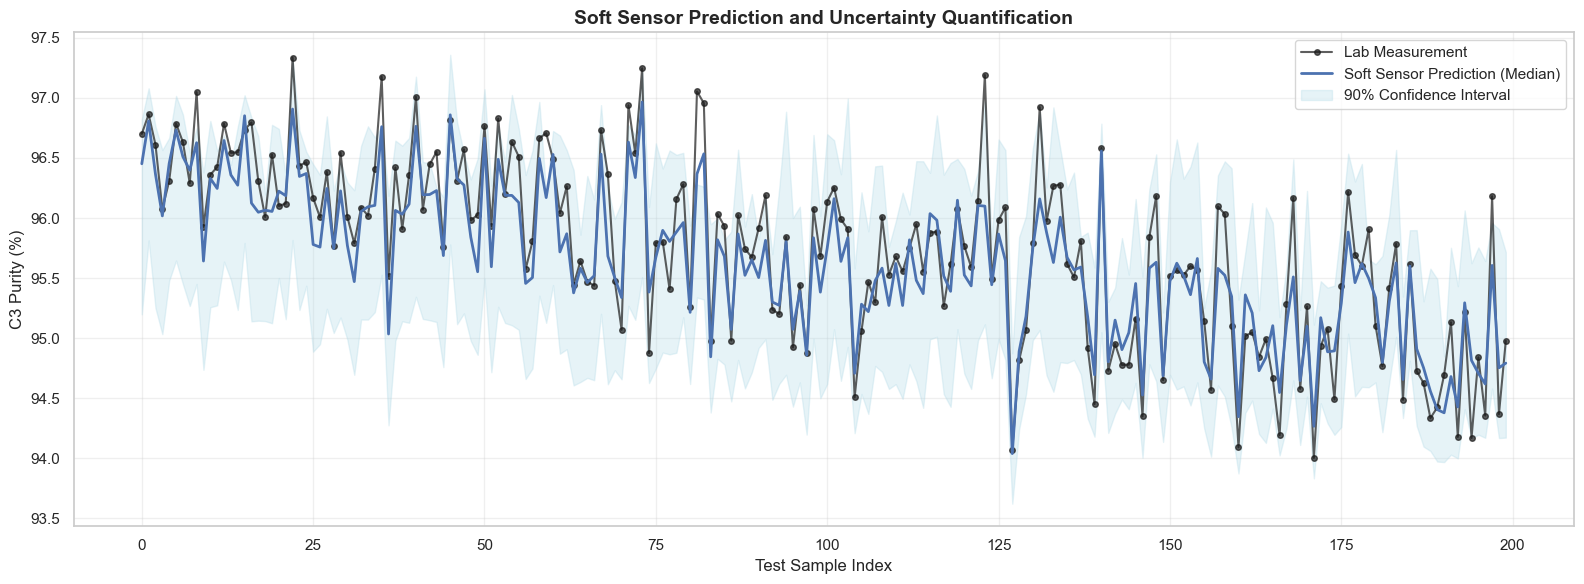

✓ 90% 預測區間的實際覆蓋率：71.36%
✓ 平均預測區間寬度：1.253%


In [31]:
# 訓練三個模型：中位數、5% 下界、95% 上界
print("訓練分位數回歸模型...")

model_median = GradientBoostingRegressor(
    loss='quantile', alpha=0.5,  # 中位數
    n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42
)

model_lower = GradientBoostingRegressor(
    loss='quantile', alpha=0.05,  # 5% 下界
    n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42
)

model_upper = GradientBoostingRegressor(
    loss='quantile', alpha=0.95,  # 95% 上界
    n_estimators=150, learning_rate=0.1, max_depth=4, random_state=42
)

# 訓練
model_median.fit(X_train_lag, y_train_dist)
model_lower.fit(X_train_lag, y_train_dist)
model_upper.fit(X_train_lag, y_train_dist)

# 預測
y_pred_median = model_median.predict(X_test_lag)
y_pred_lower = model_lower.predict(X_test_lag)
y_pred_upper = model_upper.predict(X_test_lag)

print("✓ 分位數回歸模型訓練完成\n")

# 繪製不確定性區間
fig, ax = plt.subplots(figsize=(16, 6))

# 只顯示前 200 個測試點
plot_len = min(200, len(y_test_dist))
x_axis = np.arange(plot_len)

# True values
ax.plot(x_axis, y_test_dist.iloc[:plot_len].values, 'ko-', label='Lab Measurement', 
    linewidth=1.5, markersize=4, alpha=0.7)

# Median prediction
ax.plot(x_axis, y_pred_median[:plot_len], 'b-', label='Soft Sensor Prediction (Median)', linewidth=2)

# Uncertainty interval
ax.fill_between(x_axis, 
        y_pred_lower[:plot_len], 
        y_pred_upper[:plot_len],
        alpha=0.3, color='lightblue', label='90% Confidence Interval')

ax.set_xlabel('Test Sample Index', fontsize=12)
ax.set_ylabel('C3 Purity (%)', fontsize=12)
ax.set_title('Soft Sensor Prediction and Uncertainty Quantification', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'uncertainty_quantification.png', dpi=150)
plt.show()

# 計算預測區間的覆蓋率（應接近 90%）
coverage = np.mean((y_test_dist.values >= y_pred_lower) & (y_test_dist.values <= y_pred_upper))
print(f"✓ 90% 預測區間的實際覆蓋率：{coverage*100:.2f}%")
print(f"✓ 平均預測區間寬度：{np.mean(y_pred_upper - y_pred_lower):.3f}%")


### 7.6 模型可解釋性：SHAP 分析

使用 **SHAP (SHapley Additive exPlanations)** 來解釋模型的預測決策。
這對於取得現場工程師的信任至關重要。

註：如果沒有安裝 shap 套件，請執行：`pip install shap`

計算 SHAP 值（這可能需要一點時間）...
繪製 SHAP Feature Importance...


C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_68068\2835833714.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_lag.iloc[:100],


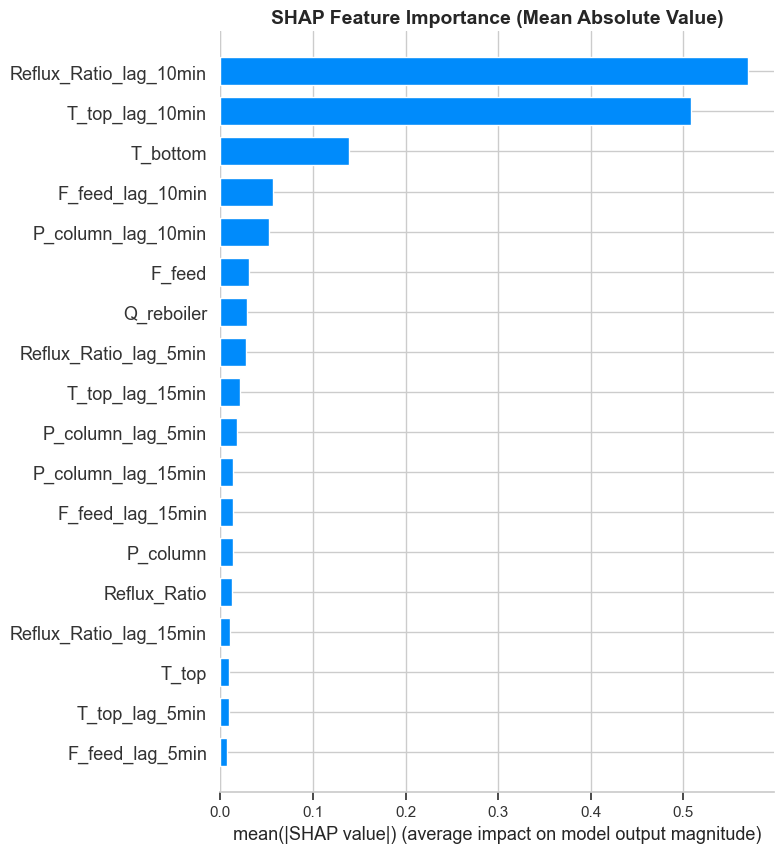

繪製 SHAP Summary Plot...


C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_68068\2835833714.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_lag.iloc[:100], show=False)


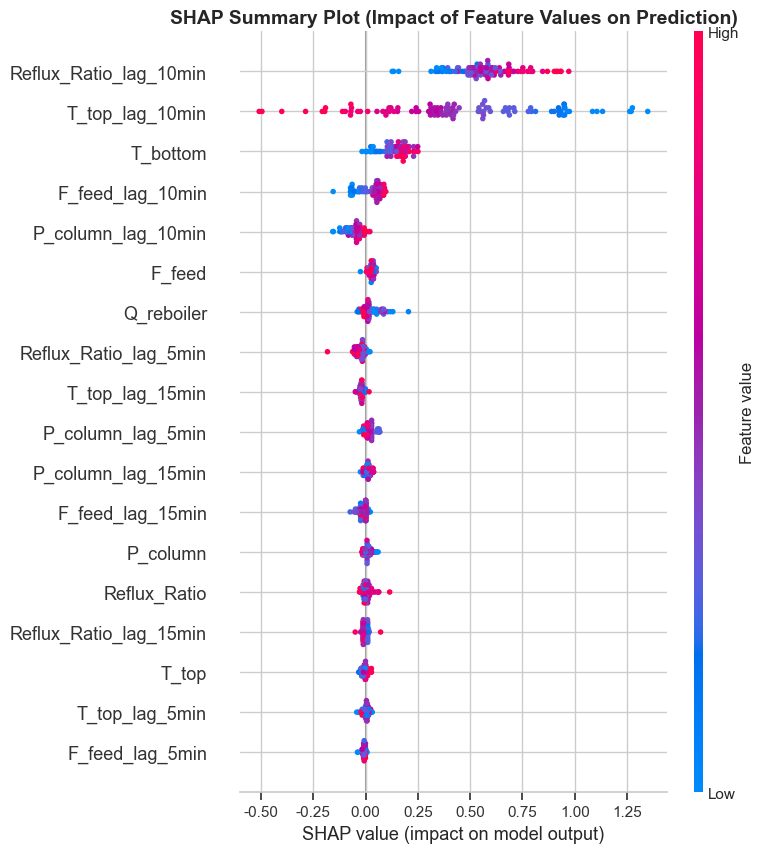

✓ SHAP 分析完成

單一預測案例解釋（測試集第 1 筆）
真實純度: 96.70%
預測純度: 96.69%

前 5 大影響因素（SHAP值）：
1. Reflux_Ratio_lag_10min   : +0.7894
2. T_top_lag_10min          : +0.5597
3. T_bottom                 : +0.1708
4. F_feed_lag_10min         : +0.0793
5. Q_reboiler               : +0.0737


In [32]:
try:
    import shap
    import warnings
    
    # 過濾 SHAP 相關的警告訊息
    warnings.filterwarnings('ignore', category=FutureWarning, module='shap')
    warnings.filterwarnings('ignore', message='IProgress not found')
    
    print("計算 SHAP 值（這可能需要一點時間）...")
    
    # 使用最佳模型
    explainer = shap.TreeExplainer(best_model)
    
    # 計算測試集的 SHAP 值（取前 100 個樣本以加快速度）
    shap_values = explainer.shap_values(X_test_lag.iloc[:100])
    
    # 1. Feature Importance (基於 SHAP)
    print("繪製 SHAP Feature Importance...")
    shap.summary_plot(shap_values, X_test_lag.iloc[:100], 
                     plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Mean Absolute Value)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'shap_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Summary Plot (Beeswarm)
    print("繪製 SHAP Summary Plot...")
    shap.summary_plot(shap_values, X_test_lag.iloc[:100], show=False)
    plt.title('SHAP Summary Plot (Impact of Feature Values on Prediction)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ SHAP 分析完成")
    
    # 解釋單一預測案例
    print("\n" + "="*60)
    print("單一預測案例解釋（測試集第 1 筆）")
    print("="*60)
    
    sample_idx = 0
    print(f"真實純度: {y_test_dist.iloc[sample_idx]:.2f}%")
    print(f"預測純度: {best_model.predict(X_test_lag.iloc[[sample_idx]])[0]:.2f}%")
    print("\n前 5 大影響因素（SHAP值）：")
    
    # 獲取該樣本的 SHAP 值
    shap_values_sample = shap_values[sample_idx]
    feature_names = X_test_lag.columns
    
    # 排序並顯示前 5 大
    top_features = np.argsort(np.abs(shap_values_sample))[-5:][::-1]
    for rank, feat_idx in enumerate(top_features, 1):
        print(f"{rank}. {feature_names[feat_idx]:25s}: {shap_values_sample[feat_idx]:+.4f}")
    
except ImportError:
    print("⚠ 未安裝 shap 套件")
    print("若要使用 SHAP 分析，請執行：pip install shap")
    print("\n跳過 SHAP 分析，繼續執行其他部分...")
except Exception as e:
    print(f"⚠ SHAP 分析時發生錯誤：{e}")
    print("跳過 SHAP 分析，繼續執行其他部分...")

---
## 11. 總結與最佳實踐

### 本單元完整涵蓋的內容

✅ **基礎概念**
- 軟感測器的定義與工業價值
- Gradient Boosting 演算法原理
- 模型評估指標（R², MAE, RMSE）

✅ **進階技術**
- 多種演算法效能比較（Linear Regression, Random Forest, Neural Network 等）
- 時間延遲處理（滯後特徵）
- 超參數調校（RandomizedSearchCV + TimeSeriesSplit）
- 不確定性量化（分位數回歸）
- 模型可解釋性（SHAP 分析）

✅ **真實案例**
- 蒸餾塔 C3/C4 分離製程模擬
- 包含 3000 個時間點的時序數據
- 多變數非線性關係建模

### 工業部署檢查清單

在實際部署軟感測器前，請確認：

**數據品質**
- [ ] 數據採樣頻率一致（或已正確對齊）
- [ ] 異常值已處理（非刪除，而是標記或修正）
- [ ] 缺失值比例 < 10%
- [ ] 特徵與目標變數的時間對齊正確

**模型穩健性**
- [ ] 使用時序切分，避免數據洩漏
- [ ] 交叉驗證 R² > 0.85
- [ ] 測試集誤差與訓練集誤差相近（無過擬合）
- [ ] 特徵重要性符合物理直覺

**部署準備**
- [ ] 模型推論時間 < 1 秒
- [ ] 建立輸入範圍檢查機制
- [ ] 提供預測不確定性估計
- [ ] 建立模型版本控制（MLflow 或 Git）
- [ ] 設計模型漂移監控機制

**維護計畫**
- [ ] 每日自動生成 Parity Plot
- [ ] 每週檢查 RMSE 趨勢
- [ ] 每月評估是否需重訓練
- [ ] 每季進行現場驗證測試

### 延伸學習方向

1. **深度學習時序模型**
   - LSTM / GRU：自動學習時間依賴性
   - Temporal Convolutional Networks (TCN)
   - Transformer for Time Series

2. **物理嵌入機器學習**
   - Physics-Informed Neural Networks (PINN)
   - 將質量守恆、能量平衡嵌入損失函數

3. **在線學習與自適應**
   - Incremental Learning
   - Online Gradient Descent
   - Ensemble Model Switching

4. **聯邦學習**
   - 多工廠協同訓練，數據不離開本地
   - 隱私保護機器學習

### 參考文獻

1. Kadlec, P., et al. (2009). "Data-driven Soft Sensors in the Process Industry." *Computers & Chemical Engineering*.
2. Fortuna, L., et al. (2007). "Soft Sensors for Monitoring and Control of Industrial Processes." *Springer*.
3. Ge, Z., et al. (2017). "Review on Data-Driven Modeling and Monitoring for Plant-Wide Industrial Processes." *Chemometrics and Intelligent Laboratory Systems*.

---

**恭喜完成 Unit 08！** 🎉

您已掌握：
- 軟感測器從數據準備到部署的完整流程
- Gradient Boosting 及其在化工製程中的應用
- 時序數據處理與時間延遲建模
- 工業級模型評估與可解釋性分析

**下一單元預告：**
在 **Unit 09: 綠色溶劑篩選** 中，我們將轉向非監督式學習，使用 K-Means 分群與 PCA 降維技術，從數千種化學物質中篩選環保溶劑。